# Team Raj Datathon 2025

### Imports & Config

In [55]:
from pathlib import Path
from typing import Dict, List, Tuple
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.linear_model import LinearRegression

from darts import TimeSeries
from darts.models import NaiveSeasonal, ExponentialSmoothing, Theta, AutoARIMA
from darts.utils.utils import SeasonalityMode

# Inline plots
# %matplotlib inline

# ---------------- CONFIG ----------------
# Tries local "data/..." first, then /mnt/data/... as a fallback (e.g., hosted envs)
DATA_PATH_CANDIDATES = [
    Path("data/climate_data_filtered_imputed.csv"),
    Path("/mnt/data/climate_data_filtered_imputed.csv"),
]

# Which station to show detailed 2024 plots for (None auto-picks a good one)
PLOT_STATION: str | None = None

# 2026 forecast settings
FORECAST_YEAR = 2026
# None => auto-pick best model from leaderboard; or set to one of MODEL_NAMES
PREDICTION_MODEL: str | None = None

# Plotting controls for 2026 per-station outputs
PLOT_MAX_STATIONS: int | None = None  # None = all stations; set to an int to limit

# Models to backtest
MODEL_NAMES = [
    "NaiveSeasonal",
    "ExponentialSmoothing",
    "Theta",
    "LinearRegression(lags)",
    "AutoARIMA",
]

# Quiet noisy warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)


### Utilities

### Station Helpers

In [56]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2)))

def sse_and_n(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, int]:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan, 0
    sse = float(np.sum((y_true[mask] - y_pred[mask]) ** 2))
    n = int(np.sum(mask))
    return sse, n

def _resolve_data_path(candidates: List[Path]) -> Path:
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find dataset at any of: {candidates}")

def load_and_prepare(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    rename_map = {
        "Bureau of Meteorology station number": "station",
        "Year": "year",
        "Week": "week",
        "Maximum temperature (Degree C)": "tmax",
        "Minimum temperature (Degree C)": "tmin",
        "Rainfall amount (millimetres)": "rain",
    }
    df = df.rename(columns=rename_map)
    df["station"] = df["station"].astype(str)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["week"] = pd.to_numeric(df["week"], errors="coerce").astype("Int64")
    for c in ["tmax", "tmin", "rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["station", "year", "week", "rain"]).copy()
    df = df.sort_values(["station", "year", "week"])
    return df

def station_series(df: pd.DataFrame, station: str) -> tuple[TimeSeries, pd.DataFrame]:
    s = df.loc[df["station"] == station].copy()
    s = s.sort_values(["year", "week"])
    s["t"] = np.arange(len(s))
    ts = TimeSeries.from_times_and_values(
        times=pd.RangeIndex(start=0, stop=len(s), step=1),
        values=s["rain"].values.astype(float),
    )
    return ts, s

def years_for_station(s: pd.DataFrame) -> List[int]:
    return (
        s[["year"]].drop_duplicates().sort_values("year").astype(int)["year"].tolist()
    )

def slices_for_year(s: pd.DataFrame, year: int) -> np.ndarray:
    return s.loc[s["year"] == year, "t"].values


### Plot Config

In [57]:
SAVE_DERIVED_CSVS = True      # set False if you don't want CSVs
DERIVED_OUTDIR = Path("data/climate_derived")
TOP_N_STATIONS = 12

### Aggregations

In [58]:
# ---- Aggregations used by the plots ----
def compute_aggregations(df: pd.DataFrame):
    """
    Returns:
      weekly_agg: median tmax/tmin/rain per week across all stations & years
      station_rain_mean: mean rainfall by station
      seasonal_rain: median seasonal rainfall (sum across weeks) by year across stations
      weeks_sorted: sorted list of week indices present
      rain_by_week: list of 1D arrays with rainfall values across station-years per week
    """
    weekly_agg = (
        df.groupby("week")[["tmax", "tmin", "rain"]]
          .median()
          .reset_index()
          .sort_values("week")
    )

    station_rain_mean = (
        df.groupby("station")["rain"]
          .mean()
          .sort_values(ascending=False)
          .reset_index()
    )

    seasonal_rain_station = (
        df.groupby(["year", "station"])["rain"]
          .sum()
          .reset_index(name="season_rain")
    )
    seasonal_rain = (
        seasonal_rain_station.groupby("year")["season_rain"]
          .median()
          .reset_index()
          .sort_values("year")
    )

    weeks_sorted = sorted(df["week"].dropna().unique())
    rain_by_week = [df.loc[df["week"] == w, "rain"].dropna().values for w in weeks_sorted]

    return weekly_agg, station_rain_mean, seasonal_rain, weeks_sorted, rain_by_week


### Plot Helpers

In [59]:
# ---- Plot helpers ----
def plot_weekly_temperature(weekly_agg: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_agg["week"], weekly_agg["tmax"], marker="o", label="Weekly median Tmax (°C)")
    plt.plot(weekly_agg["week"], weekly_agg["tmin"], marker="o", label="Weekly median Tmin (°C)")
    plt.title("Weekly Temperature Climatology (Median across stations & years)")
    plt.xlabel("Snow-season Week Index")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weekly_rainfall(weekly_agg: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_agg["week"], weekly_agg["rain"], marker="o", label="Weekly median Rainfall (mm)")
    plt.title("Weekly Rainfall Climatology (Median across stations & years)")
    plt.xlabel("Snow-season Week Index")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weekly_rain_box(rain_by_week, weeks_sorted):
    plt.figure(figsize=(12, 6))
    plt.boxplot(rain_by_week, positions=weeks_sorted, showfliers=False)
    plt.title("Weekly Rainfall Distribution Across Stations & Years")
    plt.xlabel("Snow-season Week Index")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def plot_top_stations(station_rain_mean: pd.DataFrame, top_n: int):
    top_stations = station_rain_mean.head(top_n).copy()
    plt.figure(figsize=(10, 6))
    plt.bar(top_stations["station"].astype(str), top_stations["rain"])
    plt.title(f"Top {top_n} Stations by Average Rainfall")
    plt.xlabel("Station")
    plt.ylabel("Average Rainfall (mm)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def plot_seasonal_rain_by_year(seasonal_rain: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    years = seasonal_rain["year"].astype(int).astype(str)
    plt.bar(years, seasonal_rain["season_rain"])
    plt.title("Seasonal Rainfall by Year (Median across stations)")
    plt.xlabel("Year")
    plt.ylabel("Seasonal Rainfall (mm)")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def save_derived_tables(weekly_agg, station_rain_mean, seasonal_rain, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    weekly_agg.to_csv(outdir / "weekly_climatology.csv", index=False)
    station_rain_mean.to_csv(outdir / "station_rain_mean.csv", index=False)
    seasonal_rain.to_csv(outdir / "seasonal_rain_by_year.csv", index=False)
    print(f"[saved] {outdir/'weekly_climatology.csv'}")
    print(f"[saved] {outdir/'station_rain_mean.csv'}")
    print(f"[saved] {outdir/'seasonal_rain_by_year.csv'}")


### Plotting

### Models

In [60]:
def lr_lag_forecast(train_values: np.ndarray, horizon: int, p: int) -> np.ndarray:
    y = np.asarray(train_values, dtype=float)
    if len(y) == 0:
        return np.full(horizon, np.nan)
    if len(y) <= p:
        return np.full(horizon, float(np.nanmean(y)))

    X, Y = [], []
    for i in range(p, len(y)):
        X.append(y[i - p:i][::-1])  # y[t-1], y[t-2], ...
        Y.append(y[i])
    X = np.array(X); Y = np.array(Y)
    if len(Y) == 0:
        return np.full(horizon, float(np.nanmean(y)))
    model = LinearRegression().fit(X, Y)

    history = y.copy().tolist()
    preds = []
    for _ in range(horizon):
        last_p = np.array(history[-p:][::-1]) if len(history) >= p else np.array([history[-1]] * p)
        nxt = float(model.predict(last_p.reshape(1, -1)))
        preds.append(nxt)
        history.append(nxt)
    return np.array(preds)

def _safe_ns(ts_train: TimeSeries, season: int) -> NaiveSeasonal:
    K = max(1, min(season, len(ts_train)))
    return NaiveSeasonal(K=K)

def model_predict(name: str, ts_train: TimeSeries, horizon: int, season: int) -> np.ndarray:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if len(ts_train) == 0:
            return np.full(horizon, np.nan)

        if name == "NaiveSeasonal":
            return _safe_ns(ts_train, season).fit(ts_train).predict(horizon).values().ravel()

        if name == "ExponentialSmoothing":
            return ExponentialSmoothing().fit(ts_train).predict(horizon).values().ravel()

        if name == "Theta":
            min_points = 2 * max(1, season)
            model = _safe_ns(ts_train, season) if len(ts_train) < min_points else Theta(
                seasonality_period=season, season_mode=SeasonalityMode.ADDITIVE
            )
            return model.fit(ts_train).predict(horizon).values().ravel()

        if name == "LinearRegression(lags)":
            y = ts_train.values().ravel()
            return lr_lag_forecast(y, horizon=horizon, p=max(1, season))

        if name == "AutoARIMA":
            try:
                return AutoARIMA(seasonal=False, suppress_warnings=True).fit(ts_train).predict(horizon).values().ravel()
            except Exception:
                return _safe_ns(ts_train, season).fit(ts_train).predict(horizon).values().ravel()

        raise ValueError(f"Unknown model: {name}")


### Backtesting

In [61]:
def backtest_station(
    df: pd.DataFrame, station: str, model_names: List[str]
) -> Tuple[pd.DataFrame, Dict[str, Dict[int, np.ndarray]], Dict[int, np.ndarray]]:
    ts, s = station_series(df, station)
    yrs = years_for_station(s)
    season = int(s["week"].nunique())
    metrics = []
    preds: Dict[str, Dict[int, np.ndarray]] = {m: {} for m in model_names}
    actuals: Dict[int, np.ndarray] = {}

    for i in range(1, len(yrs)):
        y_test = int(yrs[i])
        test_idx = slices_for_year(s, y_test)
        if len(test_idx) == 0:
            continue
        train_end_t = int(test_idx[0] - 1)
        ts_train = ts.drop_after(train_end_t)
        H = len(test_idx)

        y_true = s.loc[s["year"] == y_test, "rain"].astype(float).to_numpy()
        actuals[y_test] = y_true

        for name in model_names:
            try:
                y_pred = model_predict(name=name, ts_train=ts_train, horizon=H, season=season)
                fold_rmse = rmse(y_true, y_pred)
                sse, npts = sse_and_n(y_true, y_pred)
            except Exception:
                y_pred = np.full(H, np.nan)
                fold_rmse, sse, npts = np.nan, np.nan, 0

            preds[name][y_test] = y_pred
            metrics.append({"station": station, "model": name, "year": y_test,
                            "rmse": fold_rmse, "sse": sse, "n": npts})
    return pd.DataFrame(metrics), preds, actuals

def run_all(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Dict[str, Dict[int, np.ndarray]]], Dict[str, Dict[int, np.ndarray]]]:
    stations = sorted(df["station"].dropna().astype(str).unique().tolist())
    metrics_all = []
    all_preds: Dict[str, Dict[str, Dict[int, np.ndarray]]] = {}
    all_actuals: Dict[str, Dict[int, np.ndarray]] = {}
    for st in stations:
        m_df, preds, actuals = backtest_station(df, st, model_names=MODEL_NAMES)
        if not m_df.empty:
            metrics_all.append(m_df)
            all_preds[st] = preds
            all_actuals[st] = actuals
    metrics_all = pd.concat(metrics_all, ignore_index=True) if metrics_all else pd.DataFrame(
        columns=["station", "model", "year", "rmse", "sse", "n"]
    )
    return metrics_all, all_preds, all_actuals

def leaderboard_from_metrics(metrics_all: pd.DataFrame) -> pd.DataFrame:
    m = metrics_all.copy().replace([np.inf, -np.inf], np.nan).dropna(subset=["sse", "n"])
    agg = (
        m.groupby("model", as_index=False)
         .agg(
             overall_sse=("sse", "sum"),
             total_points=("n", "sum"),
             mean_rmse=("rmse", "mean"),
             median_rmse=("rmse", "median"),
             sd_rmse=("rmse", "std"),
             folds=("rmse", "count"),
         )
    )
    agg["overall_rmse"] = np.sqrt(np.where(agg["total_points"] > 0,
                                           agg["overall_sse"] / agg["total_points"], np.nan))
    lb = agg.sort_values("overall_rmse").reset_index(drop=True)
    lb.insert(0, "rank", np.arange(1, len(lb) + 1))
    return lb[["rank", "model", "overall_rmse", "total_points", "folds", "mean_rmse", "median_rmse", "sd_rmse"]]


### Leaderboard

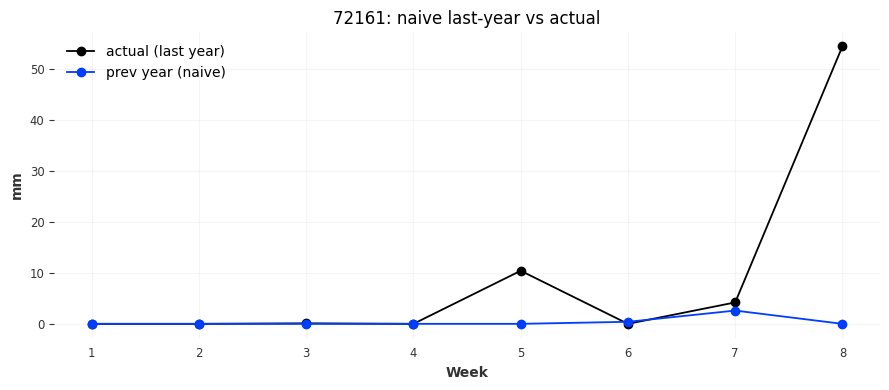

In [62]:
# naive "last-year same week" comparator
d = d.sort_values(["year","week"])
weeks_per_year = d.groupby("year")["week"].nunique().mode().iloc[0]
prev = d[d["year"]== (d["year"].max()-1)]["rain"].to_numpy()
cur  = d[d["year"]== d["year"].max()]["rain"].to_numpy()
L = min(len(prev), len(cur))
plt.figure(figsize=(9,4))
plt.plot(range(1,L+1), cur[:L], marker="o", label="actual (last year)")
plt.plot(range(1,L+1), prev[:L], marker="o", label="prev year (naive)")
plt.title("72161: naive last-year vs actual"); plt.xlabel("Week"); plt.ylabel("mm")
plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


### Plotting

In [63]:
def pick_station_for_plot(df: pd.DataFrame) -> str | None:
    by_station = (
        df.groupby("station")
        .agg(years=("year", lambda x: sorted(set(int(y) for y in x))),
             n_2024=("year", lambda x: int(np.sum(x == 2024))))
        .reset_index()
    )
    candidates = by_station[(by_station["n_2024"] > 0) & (by_station["years"].apply(lambda ys: any(y < 2024 for y in ys)))]
    if candidates.empty:
        return None
    candidates["history_len"] = candidates["years"].apply(len)
    return str(candidates.sort_values(["history_len", "station"], ascending=[False, True]).iloc[0]["station"])

def plot_and_table_2024_per_model(
    df: pd.DataFrame,
    station: str,
    preds: Dict[str, Dict[int, np.ndarray]],
    actuals: Dict[int, np.ndarray],
    model_order: List[str],
) -> None:
    _, s = station_series(df, station)
    if 2024 not in actuals:
        print(f"[plot] Station {station} has no 2024 backtest.")
        return
    weeks_2024 = s.loc[s["year"] == 2024, "week"].astype(int).tolist()
    y_true = actuals[2024]

    display(Markdown(f"## 2024 Predicted vs Actual — Station `{station}`"))
    for name in model_order:
        y_pred = preds.get(name, {}).get(2024, None)
        if y_pred is None or not np.any(np.isfinite(y_pred)):
            continue
        score = rmse(y_true, y_pred)

        # Plot
        plt.figure(figsize=(9, 4.5))
        plt.plot(weeks_2024, y_true, marker="o", label="Actual 2024")
        plt.plot(weeks_2024, y_pred, marker="o", label=f"{name} (pred)")
        plt.title(f"{name} | RMSE={score:.3f}")
        plt.xlabel("Week")
        plt.ylabel("Rainfall (mm)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Table under plot
        tbl = pd.DataFrame({
            "week": weeks_2024,
            "actual_2024": y_true,
            "pred_2024": y_pred,
            "error": y_pred - y_true,
            "abs_error": np.abs(y_pred - y_true),
        })
        display(tbl.round(3))


### 2026 Predictions

In [64]:
def _forecast_season_for_station(
    df: pd.DataFrame,
    station: str,
    model_name: str,
    year: int
) -> Tuple[pd.DataFrame, np.ndarray, List[int]]:
    """
    Robust forecast for one station:
      - aggregate to unique (year, week)
      - drop outlier last year if extreme
      - winsorize per-year spikes
      - use robust season length
    """
    # Slice and sanitize this station's history
    s = (df.loc[df["station"] == station, ["year", "week", "rain"]]
            .dropna(subset=["year", "week", "rain"])
            .astype({"year": "int64", "week": "int64"})
            .sort_values(["year", "week"]))

    # Aggregate duplicates just in case
    s = s.groupby(["year", "week"], as_index=False)["rain"].mean()

    # Robustify: drop extreme last year (e.g., 2025 for 72161), then clip spikes
    s = drop_outlier_last_year(s, col="rain", mult=3.0)
    s = winsorize_station_year(s, col="rain", upper_q=0.99, mult=3.0, by="year")

    # Season length and forecast horizon
    season = robust_season_length(s)
    H = season

    # Clean TimeSeries
    ts_train = build_ts_from_station_frame(s, col="rain")

    # Forecast
    y_pred = model_predict(name=model_name, ts_train=ts_train, horizon=H, season=season)

    # Weeks axis
    weeks = sorted(s["week"].unique().tolist())
    if len(weeks) != H:
        weeks = list(range(1, H + 1))

    out = pd.DataFrame(
        {"station": str(station), "year": int(year), "week": weeks, "predicted_rain": y_pred}
    )
    return out, y_pred, weeks


def forecast_2026_all_stations(
    df: pd.DataFrame,
    model_name: str,
    year: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Forecast each station robustly and return long + wide tables."""
    stations = sorted(df["station"].dropna().astype(str).unique().tolist())
    all_rows = []
    for st in stations:
        try:
            rows, _, _ = _forecast_season_for_station(df, st, model_name, year)
        except Exception as e:
            # Keep the pipeline running; mark NaNs for stations that fail
            # (unlikely with the robust guards, but defensive)
            season = int(df.loc[df["station"] == st, "week"].nunique())
            weeks = list(range(1, season + 1)) if season > 0 else []
            rows = pd.DataFrame({
                "station": str(st), "year": int(year),
                "week": weeks, "predicted_rain": [np.nan] * len(weeks)
            })
        all_rows.append(rows)

    long_df = pd.concat(all_rows, ignore_index=True)
    wide_df = (
        long_df.pivot_table(index="station", columns="week", values="predicted_rain", aggfunc="first")
                .sort_index().sort_index(axis=1)
    )
    return long_df, wide_df


### Run Backtest

In [65]:
# ---------- Add these helpers once ----------
def robust_season_length(s: pd.DataFrame) -> int:
    """Use the most common weeks-per-year instead of overall nunique."""
    wc = s.groupby("year")["week"].nunique()
    return int(wc.mode().iloc[0]) if not wc.empty else int(s["week"].nunique())

def winsorize_station_year(
    s: pd.DataFrame,
    col: str = "rain",
    upper_q: float = 0.99,
    mult: float = 3.0,
    by: str = "year",
) -> pd.DataFrame:
    """Clip extremes per year at (year 99th percentile × mult)."""
    s = s.copy()
    caps = s.groupby(by)[col].quantile(upper_q)
    def _cap_row(r):
        cap = caps.get(r[by], np.nan)
        if pd.isna(cap):
            return r[col]
        return min(r[col], cap * mult)
    s[col] = s.apply(_cap_row, axis=1)
    return s

def drop_outlier_last_year(s: pd.DataFrame, col: str = "rain", mult: float = 3.0) -> pd.DataFrame:
    """
    If the last year's 95th percentile is > mult × the historical 95th,
    drop the last year (e.g., a partial season with huge spikes).
    """
    yrs = sorted(s["year"].unique())
    if len(yrs) < 2:
        return s
    last = yrs[-1]
    hist = s[s["year"] != last][col]
    if hist.notna().sum() < 10:
        return s
    hist_p95 = hist.quantile(0.95)
    last_p95 = s[s["year"] == last][col].quantile(0.95)
    if pd.notna(hist_p95) and pd.notna(last_p95) and last_p95 > mult * hist_p95:
        return s[s["year"] != last].copy()
    return s

def build_ts_from_station_frame(s: pd.DataFrame, col: str = "rain") -> TimeSeries:
    """Create a clean equidistant TimeSeries from a (year, week, rain) frame."""
    vals = s[col].astype(float).to_numpy()
    return TimeSeries.from_times_and_values(times=pd.RangeIndex(len(vals)), values=vals)


Backtesting models per station...

=== Leaderboard (Overall RMSE across all stations/years/weeks; lower is better) ===
 rank                  model  overall_rmse  total_points  folds  mean_rmse  median_rmse    sd_rmse
    1   ExponentialSmoothing      4.773185          1000     70   4.212256     3.427149   3.400114
    2                  Theta      4.856898          1105     77   4.287338     3.324407   3.320312
    3          NaiveSeasonal      5.421287          1105     77   4.952435     4.291387   3.291846
    4              AutoARIMA      5.421287          1105     77   4.952435     4.291387   3.291846
    5 LinearRegression(lags)    149.191728          1105     77  20.932917     3.323992 145.387920


,rank,model,overall_rmse,total_points,folds,mean_rmse,median_rmse,sd_rmse
0,1,ExponentialSmoothing,4.773,1000,70,4.212,3.427,3.400
1,2,Theta,4.857,1105,77,4.287,3.324,3.320
2,3,NaiveSeasonal,5.421,1105,77,4.952,4.291,3.292
3,4,AutoARIMA,5.421,1105,77,4.952,4.291,3.292
4,5,LinearRegression(lags),149.192,1105,77,20.933,3.324,145.388


## 2024 Predicted vs Actual — Station `71032`

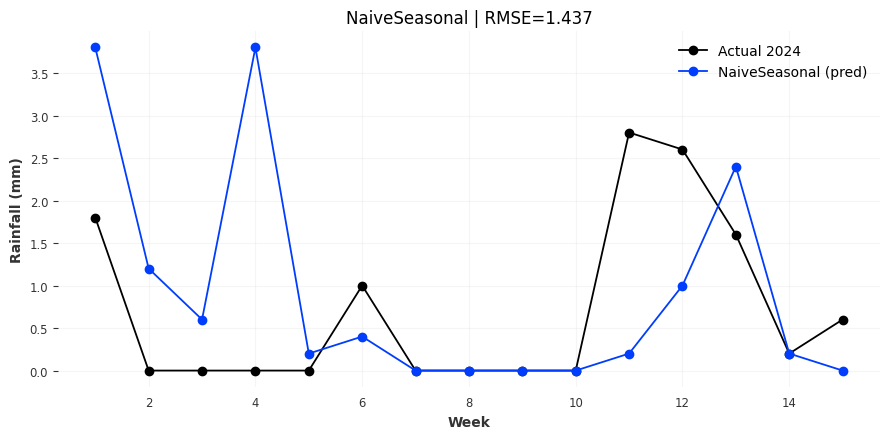

,week,actual_2024,pred_2024,error,abs_error
0,1,1.8,3.8,2.0,2.0
1,2,0.0,1.2,1.2,1.2
2,3,0.0,0.6,0.6,0.6
3,4,0.0,3.8,3.8,3.8
4,5,0.0,0.2,0.2,0.2
5,6,1.0,0.4,-0.6,0.6
6,7,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0


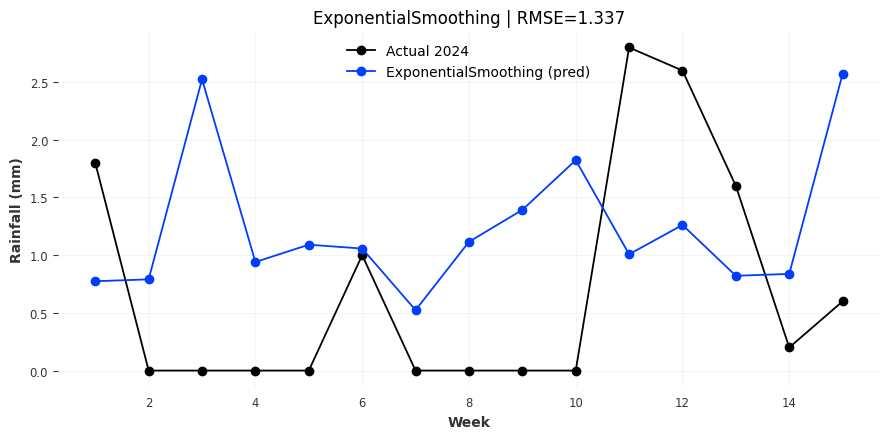

,week,actual_2024,pred_2024,error,abs_error
0,1,1.8,0.774,-1.026,1.026
1,2,0.0,0.791,0.791,0.791
2,3,0.0,2.524,2.524,2.524
3,4,0.0,0.941,0.941,0.941
4,5,0.0,1.091,1.091,1.091
5,6,1.0,1.057,0.057,0.057
6,7,0.0,0.524,0.524,0.524
7,8,0.0,1.116,1.116,1.116
8,9,0.0,1.393,1.393,1.393
9,10,0.0,1.823,1.823,1.823


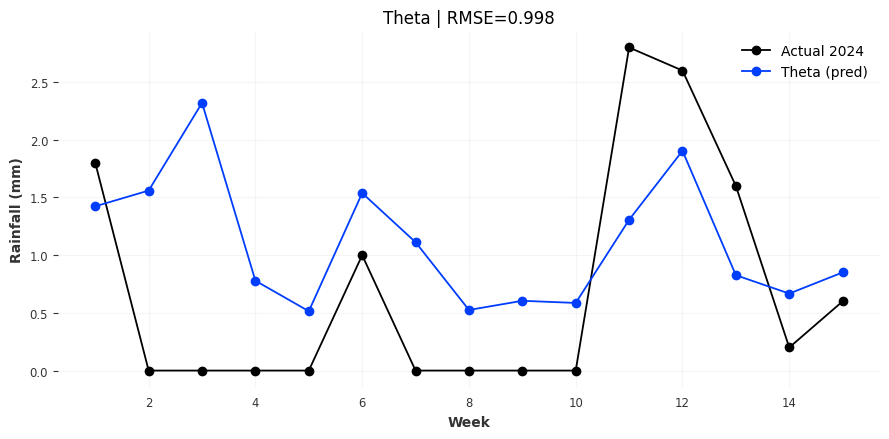

,week,actual_2024,pred_2024,error,abs_error
0,1,1.8,1.424,-0.376,0.376
1,2,0.0,1.560,1.560,1.560
2,3,0.0,2.320,2.320,2.320
3,4,0.0,0.779,0.779,0.779
4,5,0.0,0.515,0.515,0.515
5,6,1.0,1.539,0.539,0.539
6,7,0.0,1.112,1.112,1.112
7,8,0.0,0.525,0.525,0.525
8,9,0.0,0.605,0.605,0.605
9,10,0.0,0.586,0.586,0.586


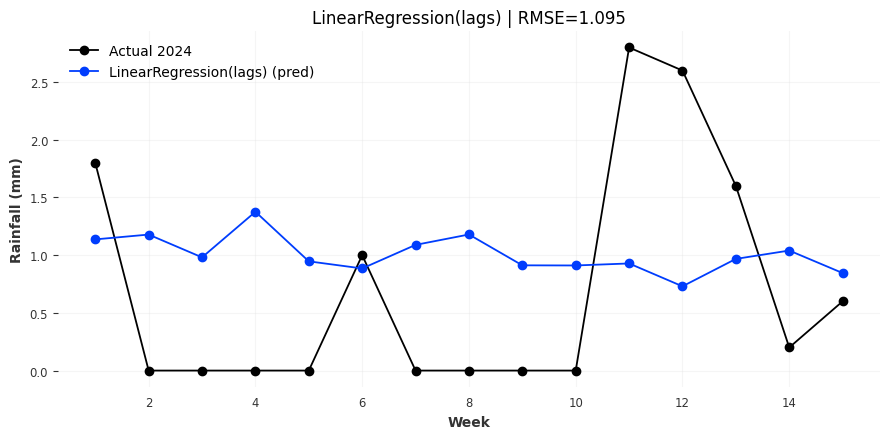

,week,actual_2024,pred_2024,error,abs_error
0,1,1.8,1.137,-0.663,0.663
1,2,0.0,1.179,1.179,1.179
2,3,0.0,0.981,0.981,0.981
3,4,0.0,1.376,1.376,1.376
4,5,0.0,0.947,0.947,0.947
5,6,1.0,0.885,-0.115,0.115
6,7,0.0,1.089,1.089,1.089
7,8,0.0,1.179,1.179,1.179
8,9,0.0,0.912,0.912,0.912
9,10,0.0,0.911,0.911,0.911


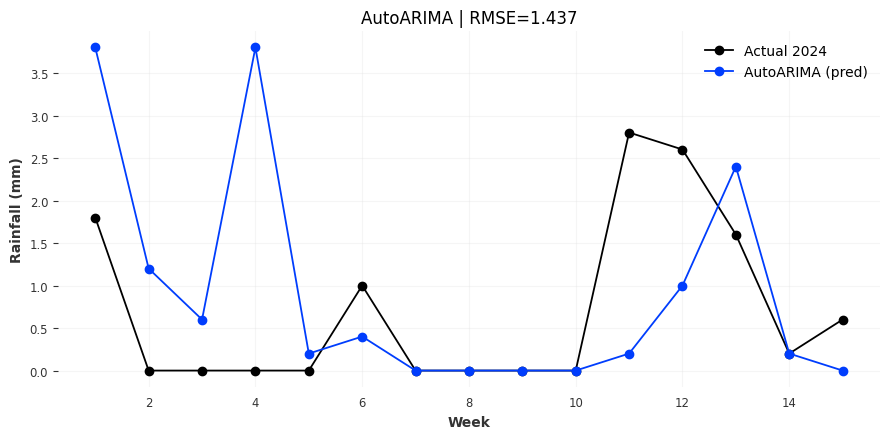

,week,actual_2024,pred_2024,error,abs_error
0,1,1.8,3.8,2.0,2.0
1,2,0.0,1.2,1.2,1.2
2,3,0.0,0.6,0.6,0.6
3,4,0.0,3.8,3.8,3.8
4,5,0.0,0.2,0.2,0.2
5,6,1.0,0.4,-0.6,0.6
6,7,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0



Forecasting 2026 weekly rainfall using model: ExponentialSmoothing


## Overview table — 2026 predictions (stations × weeks)

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
station,,,,,,,,,,,,,,,
71032,1.202,0.723,0.795,2.052,0.723,0.837,0.780,0.395,0.827,1.173,1.440,0.813,1.220,0.741,0.813
71075,2.087,0.879,3.422,2.094,2.530,1.994,0.894,2.565,2.552,4.725,1.885,6.605,2.071,0.863,3.406
72161,0.930,0.083,-0.040,0.700,0.214,2.571,1.100,1.121,1.121,-0.029,1.564,0.443,0.852,0.006,-0.117
83024,1.483,2.155,3.976,2.733,2.970,1.997,0.927,2.917,2.590,3.070,3.017,4.777,1.462,2.134,3.955
83084,2.429,2.745,2.738,2.514,2.143,2.786,2.057,1.971,2.571,1.800,3.971,2.056,2.530,2.846,2.838
83085,1.226,2.341,1.718,1.725,1.725,2.911,2.168,2.268,1.568,3.375,2.368,1.483,1.341,2.457,1.834
85291,2.462,2.169,3.327,3.712,2.462,4.427,5.655,3.258,3.711,3.431,1.838,5.478,2.509,2.216,3.374


## 2026 Predicted Weekly Rainfall — Model `ExponentialSmoothing`

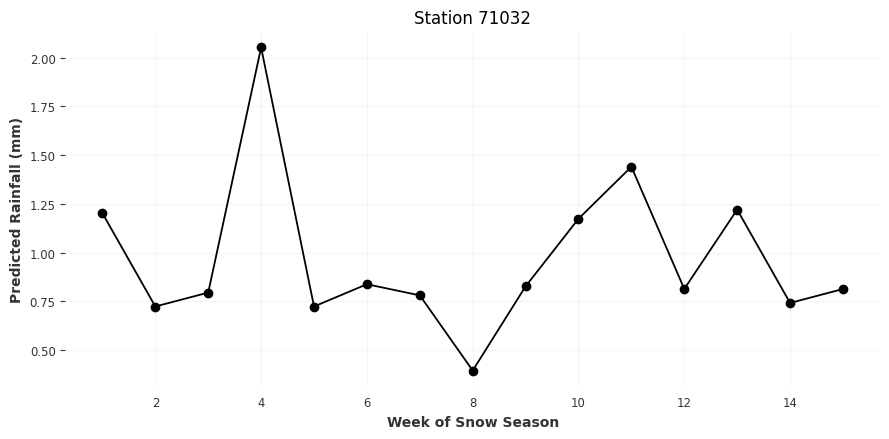

,station,year,week,predicted_rain
0,71032,2026,1,1.202
1,71032,2026,2,0.723
2,71032,2026,3,0.795
3,71032,2026,4,2.052
4,71032,2026,5,0.723
5,71032,2026,6,0.837
6,71032,2026,7,0.780
7,71032,2026,8,0.395
8,71032,2026,9,0.827
9,71032,2026,10,1.173


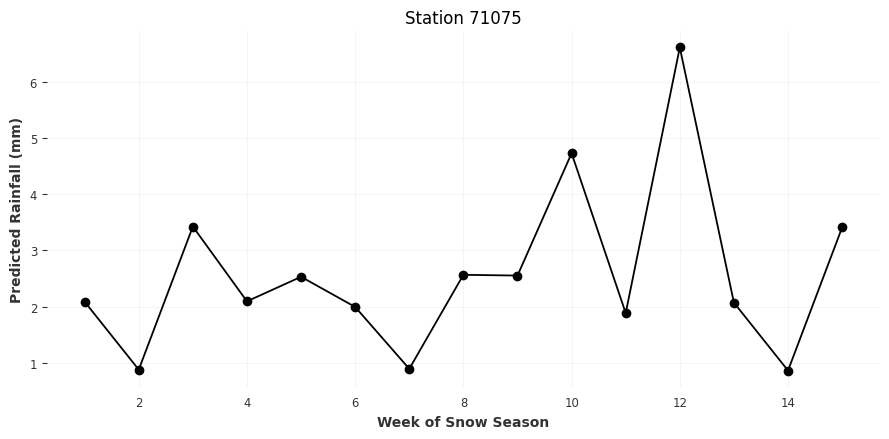

,station,year,week,predicted_rain
0,71075,2026,1,2.087
1,71075,2026,2,0.879
2,71075,2026,3,3.422
3,71075,2026,4,2.094
4,71075,2026,5,2.530
5,71075,2026,6,1.994
6,71075,2026,7,0.894
7,71075,2026,8,2.565
8,71075,2026,9,2.552
9,71075,2026,10,4.725


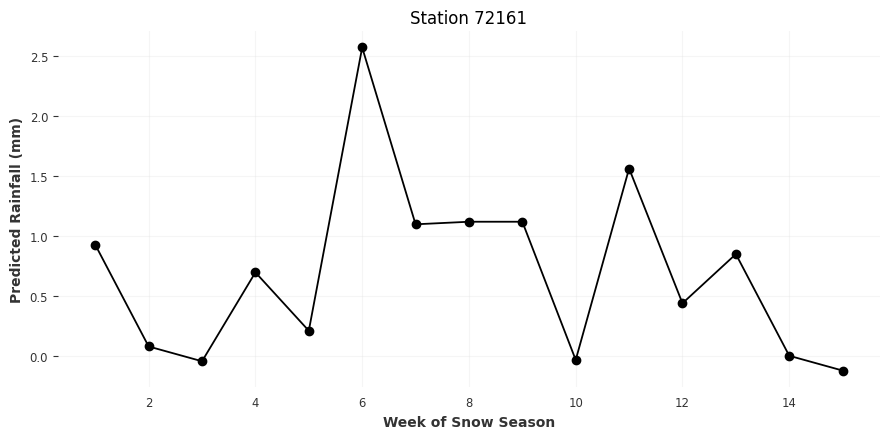

,station,year,week,predicted_rain
0,72161,2026,1,0.930
1,72161,2026,2,0.083
2,72161,2026,3,-0.040
3,72161,2026,4,0.700
4,72161,2026,5,0.214
5,72161,2026,6,2.571
6,72161,2026,7,1.100
7,72161,2026,8,1.121
8,72161,2026,9,1.121
9,72161,2026,10,-0.029


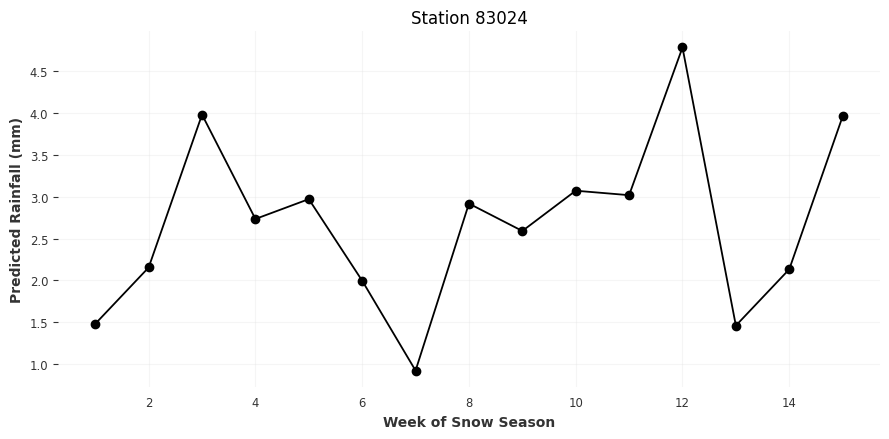

,station,year,week,predicted_rain
0,83024,2026,1,1.483
1,83024,2026,2,2.155
2,83024,2026,3,3.976
3,83024,2026,4,2.733
4,83024,2026,5,2.970
5,83024,2026,6,1.997
6,83024,2026,7,0.927
7,83024,2026,8,2.917
8,83024,2026,9,2.590
9,83024,2026,10,3.070


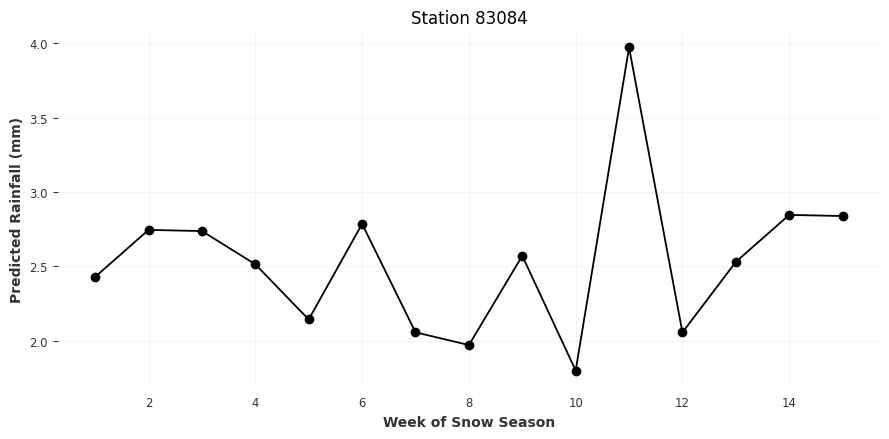

,station,year,week,predicted_rain
0,83084,2026,1,2.429
1,83084,2026,2,2.745
2,83084,2026,3,2.738
3,83084,2026,4,2.514
4,83084,2026,5,2.143
5,83084,2026,6,2.786
6,83084,2026,7,2.057
7,83084,2026,8,1.971
8,83084,2026,9,2.571
9,83084,2026,10,1.800


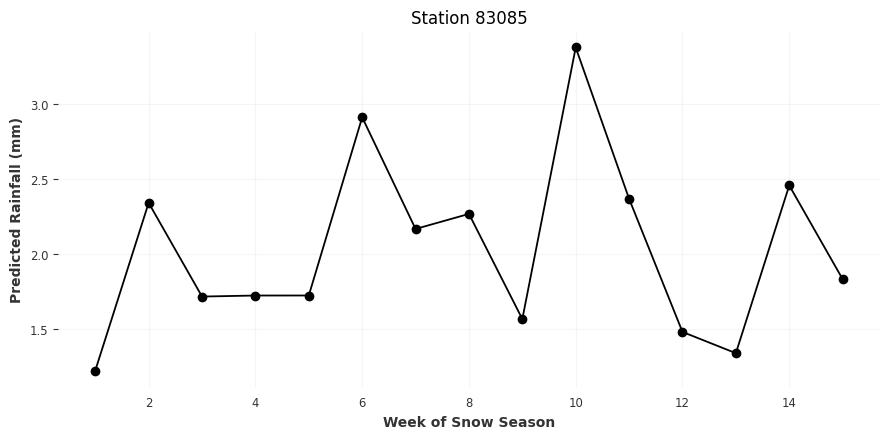

,station,year,week,predicted_rain
0,83085,2026,1,1.226
1,83085,2026,2,2.341
2,83085,2026,3,1.718
3,83085,2026,4,1.725
4,83085,2026,5,1.725
5,83085,2026,6,2.911
6,83085,2026,7,2.168
7,83085,2026,8,2.268
8,83085,2026,9,1.568
9,83085,2026,10,3.375


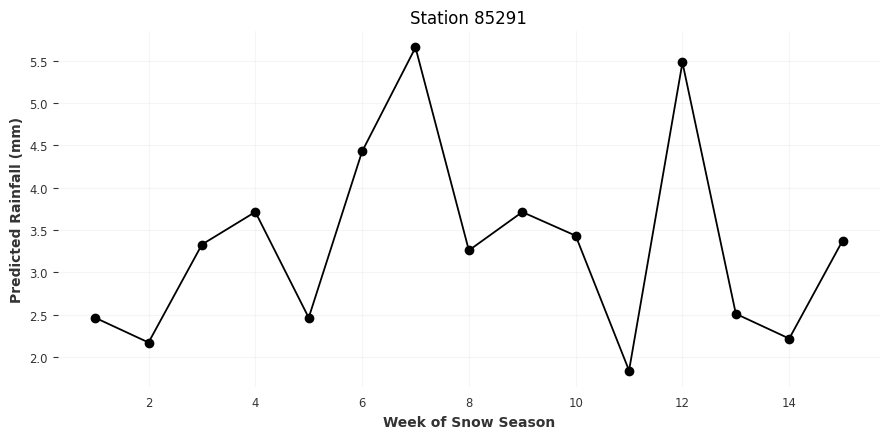

,station,year,week,predicted_rain
0,85291,2026,1,2.462
1,85291,2026,2,2.169
2,85291,2026,3,3.327
3,85291,2026,4,3.712
4,85291,2026,5,2.462
5,85291,2026,6,4.427
6,85291,2026,7,5.655
7,85291,2026,8,3.258
8,85291,2026,9,3.711
9,85291,2026,10,3.431


In [66]:
# Load data
DATA_PATH = _resolve_data_path(DATA_PATH_CANDIDATES)
df = load_and_prepare(DATA_PATH)

# Backtest & leaderboard
print("Backtesting models per station...")
metrics_all, all_preds, all_actuals = run_all(df)

if metrics_all.empty:
    raise RuntimeError("No metrics produced — check input data.")

# Leaderboard (printed + displayed)
leaderboard = leaderboard_from_metrics(metrics_all)
print("\n=== Leaderboard (Overall RMSE across all stations/years/weeks; lower is better) ===")
print(leaderboard.to_string(index=False))
display(leaderboard.style.format({"overall_rmse": "{:.3f}", "mean_rmse": "{:.3f}", "median_rmse": "{:.3f}", "sd_rmse": "{:.3f}"}))

# 2024: predicted vs actual plots for each model (one station)
station = PLOT_STATION or pick_station_for_plot(df)
if station is None:
    print("\nNo suitable station found with both 2024 data and prior training years.")
else:
    plot_and_table_2024_per_model(
        df,
        station,
        preds=all_preds.get(station, {}),
        actuals=all_actuals.get(station, {}),
        model_order=MODEL_NAMES,
    )

# 2026: choose model (explicit or best from leaderboard), then plot+table for each station
chosen_model = PREDICTION_MODEL or (leaderboard.iloc[0]["model"] if not leaderboard.empty else "ExponentialSmoothing")
print(f"\nForecasting {FORECAST_YEAR} weekly rainfall using model: {chosen_model}")

forecast_long, forecast_wide = forecast_2026_all_stations(
    df,
    model_name=chosen_model,
    year=FORECAST_YEAR,
)

# Show an overview table first (stations x weeks)
display(Markdown(f"## Overview table — {FORECAST_YEAR} predictions (stations × weeks)"))
display(forecast_wide.round(3))

# Then per-station figure + table
plot_and_table_2026_per_station(
    long_df=forecast_long,
    model_name=chosen_model,
    year=FORECAST_YEAR,
    max_stations=PLOT_MAX_STATIONS,  # set to an int to limit the number of outputs
)
